## Imports & Setup

In [25]:
# DO NOT DELETE THIS CELL
# Load useful libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import sys
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import Accuracy

# Plotting libraries
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# utility imports
import importlib

In [26]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [27]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Mount Google Drive

In [28]:
if 'google.colab' in str(get_ipython()):
  # Running in Google Colab.
  # 1. Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # 2. Install a few dependencies
  !pip install --upgrade tensorflow-addons tf_keras_vis

  # 3. Make sure we can find the data
  data_dir = "/content/drive/MyDrive/cs109b/project/data/"
else:
  # 1. Set the data dir for local development
  data_dir = "data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.7/dist-packages (0.12.1)
Requirement already up-to-date: tf_keras_vis in /usr/local/lib/python3.7/dist-packages (0.5.5)


## Dataset & tools download

In [35]:
##################################################
# Code borrowed from CS109b assignment notebooks #
#            (with mild tweaks)                  #
##################################################

def download_dataset(    
    url, 
    filename,
    filepath,
    dirname,
    dirpath,    
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(dirpath):
        print(
            "Congratulations...the dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract dataset if it doesn't already exist
    else:
        print(f"Downloading dataset to {filepath}\n")

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            print(f"...downloading a {(length/1e9):.2f} GB file."
                "This is going to take a while!"
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print(f"...{filename} download complete :o)")
        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            f"...extracting {filename}. \n"
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(f"The dataset has been extracted to: \n\n\t{dirpath}\n")            

In [55]:
%%time
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

# dataset params
dataset_url = "https://fusion-360-gallery-dataset.s3-us-west-2.amazonaws.com/reconstruction/r1.0.0/r1.0.0.zip"
filename = "r1.0.0.zip"
dirname = f"{data_dir}reconstruction"
dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

download_dataset(dataset_url, filename, filepath, data_dir, dirpath)

# Final locatioin of the dataset
dataset_path = f"{dirname}/r1.0.0/"
train_test_file = f"{dataset_path}train_test.json"

Congratulations...the dataset already exists locally!
No new downloads are required :o)

CPU times: user 1.04 ms, sys: 0 ns, total: 1.04 ms
Wall time: 1.47 ms


In [37]:
def download_file(url: str, filepath: str):
  dir = os.path.dirname(filepath)
  if not os.path.isdir(dir):
      os.makedirs(dir)

  with requests.get(url, stream=True) as r:      
      with open(filepath, 'wb') as f:
        f.write(r.content)

tools_path = f"{data_dir}tools/"
download_file(
  "https://raw.githubusercontent.com/AutodeskAILab/Fusion360GalleryDataset/master/tools/sketch2image/sketch_plotter.py",
  f"{tools_path}sketch_plotter.py"
)      

# Append tools directory to path so we can import from it
sys.path.append(os.path.abspath(tools_path))

In [99]:
def get_sketches(path):
  """ Returns a list of json objects representing sketches"""
  # Load up the data file
  with open(metadata_file, 'r') as f:
    data_json = json.load(f)
  
  # The file will contain multiple sketches, so pull the ids ...
  entity_ids = list(data_json['entities'].keys())

  # not all entities will be sketches, so filter ... 
  sketch_ids = [id for id in entity_ids if data_json['entities'][id]["type"] == "Sketch"]

  return [data_json['entities'][id] for id in sketch_ids]

def draw_sketches(sketches):
  """ Draws the given sketches """
  for sketch in sketches:
    plotter = SketchPlotter(sketch)
    try:
      plotter.create_drawing()
    except KeyError:
      continue

Warning! -- Curve type SketchFittedSpline is not supported yet
Warning! -- Curve type SketchFittedSpline is not supported yet


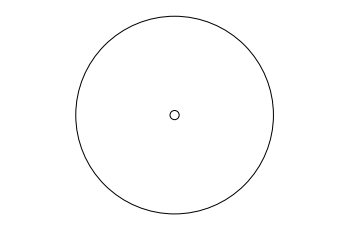

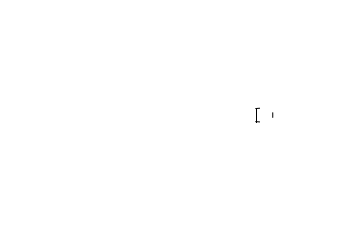

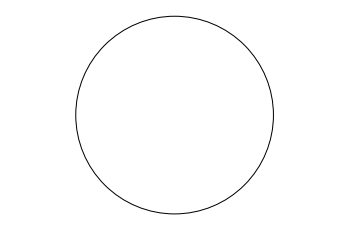

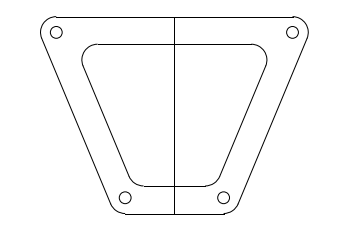

In [101]:
from sketch_plotter import SketchPlotter
import json

# Load train/test json file 
with open(train_test_file, 'r') as f:
  train_test_json = json.load(f)

# Randomly select some ids from the training set
n = 2
random_train_ids = np.random.choice(train_test_json['train'], n)

for id in random_train_ids:
  metadata_file = f"{dataset_path}reconstruction/{id}.json"
  sketches = get_sketches(metadata_file)
  draw_sketches(sketches=sketches)